In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import PIL
from PIL import ImageOps, ImageFilter
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Numpy        : 1.23.5
Tensorflow   : 2.15.0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/'My Drive'/DLMIPT/miptbio-car-classification.zip .

In [ ]:
!ls

gdrive	miptbio-car-classification.zip	sample_data


In [ ]:
zip_file_path = '/content/miptbio-car-classification.zip'

extracted_folder_path = '/content/'

os.makedirs(extracted_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f"Файлы были успешно извлечены в {extracted_folder_path}")


Файлы были успешно извлечены в /content/


In [ ]:
DATA_PATH = '/content/miptbio-car-classification'
DATA_DIR = '/content/miptbio-car-classification/train/train/train'
TEST_DIR = '/content/miptbio-car-classification/test/test/test_upload'
CHECKPOINT_PATH = 'models/'

In [ ]:
IMAGE_SIZE = [250, 250]
IMAGE_CHANEL = [3]
INPUT_SHAPE = IMAGE_SIZE + IMAGE_CHANEL
CLASS_NUM = 10
RANDOM_SEED = 19812
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4

In [ ]:
def plot_sample_images(data, path_to_images, path_col='Id', class_col='Category', image_count=6):
    """
    Функция для вывода нескольких изображений на экран.
    Пути до изображений и классы, которые им соответствуют хранятся в pd.DataFrame
    Директория с изображениями должна быть организована по принципу имя класса: изображения, соответствующее этому классу
    Аргументы:
        data -> pd.DataFrame - датафрейм в котором хранятся имена файлов и метки классов, соответствующих им
        path_to_images -> str - путь до папки, в которой хранятся изображения
        path_col -> str - имя столбца датафрейма, в котором хранятся имена файлов
        class_col -> str - имя столбца датафрейма, в которой хранятся метки классов
        image_count -> int - количество выводимых изображений
    """
    fig = plt.figure(figsize=(12, 8)) #создаем фигуру
    random_image = data.sample(n=image_count) #случайный выбор n строк из таблицы
    random_image_paths = random_image[path_col].values #пути до файлов
    random_image_cat = random_image[class_col].values #метки классов
    for index, path in enumerate(random_image_paths): #цикл по пронумерованным путям
        class_label = str(random_image_cat[index])
        img = tf.keras.preprocessing.image.load_img(os.path.join(path_to_images, class_label, path)) #читаем изображение
        plt.subplot(3, 3, index + 1) # добавляем холст для вывода изображений
        plt.imshow(img) #вывод изображения на экран
        plt.title('Class: ' + str(random_image_cat[index])) #даем название холсту
        plt.axis('off') #отключаем оси
    plt.show()

In [ ]:
def plot_sample_images_generator(generator, count_images=6):
    """
    Функция для вывода нескольких изображений на экран
    Изображения задаются из генератора изображений tensorflow
    Аргументы:
        generator -> tensorflow.keras.preprocessing.image.ImageDataGenerator - генератор изображений
        count_images -> int - количество выводимых изображений
    """
    x, y = generator.next() #получаем batch изображений из генератора:
    #x - тензор размера (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE)
    #y - вектор размера BATCH_SIZE
    fig = plt.figure(figsize=(30, 10)) #создаем фигуру
    for i in range(count_images): #цикл по индексам изображений
        image = x[i] #достаем iое изображение
        plt.subplot(3, 3, i + 1) #добавляем холст
        plt.imshow(image) #выводим изображение
        plt.title('Class: ' + str(y[i])) #даем название холсту
    plt.show()

In [ ]:
def plot_history(history):
    """
    Функция для вывода графиков обучения
    Аргументы:
        history - история обучения, полученная из метода fit модели keras
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'])

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'])
    plt.show()

In [ ]:
def plot_classes_balance(data, class_col = 'Category'):
    """
    Функция для вывода баланса классов в виде bar-диаграммы
    Аргументы:
        data -> pd.DataFrame - датафрейм, содержащий метки классов
        class_col -> str - имя столбца с метками классов
    """
    fig = plt.figure(figsize=(12, 8))
    percentage_data = data[class_col].value_counts(normalize=True).rename('percentage').reset_index()
    sns.barplot(x='index', y='percentage', data=percentage_data)

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
print(os.path.join(DATA_PATH, 'train.csv'))
print(f'Shape: {train_df.shape}')
train_df.head()

/content/miptbio-car-classification/train.csv
Shape: (15561, 2)


,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
submission = pd.read_csv(os.path.join(DATA_PATH, 'sample-submission.csv'))
print(f'Shape: {submission.shape}')
submission.head()

Shape: (6675, 2)


,Id,Category
0,305108.jpg,0
1,295075.jpg,0
2,31197.jpg,0
3,93598.jpg,0
4,87877.jpg,0


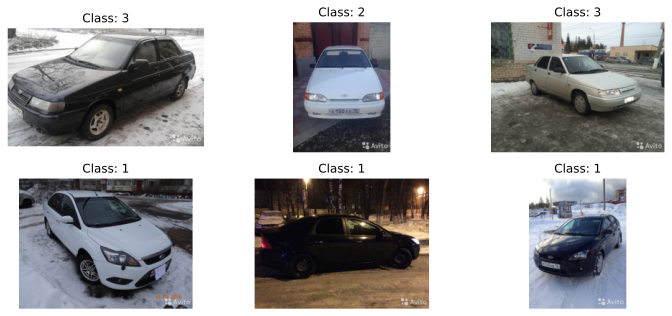

In [ ]:
plot_sample_images(data=train_df, path_to_images=DATA_DIR)

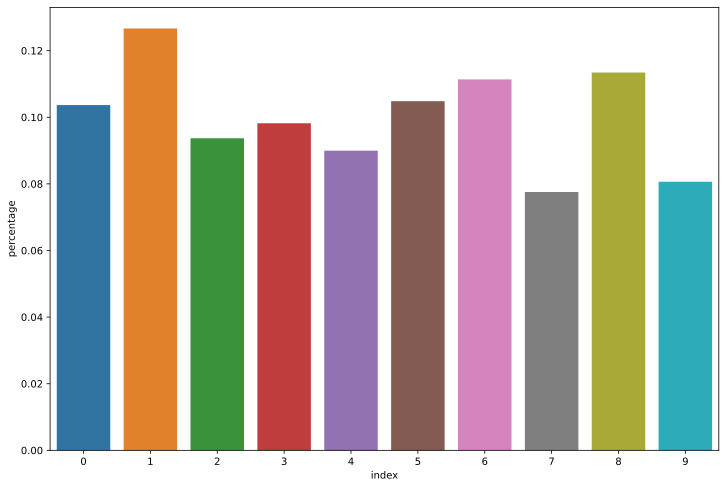

In [ ]:
plot_classes_balance(data=train_df)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15, #диапазон изображения в градусах
    width_shift_range=0.1, #смещение изображения по ширине
    height_shift_range=0.1, #смещение изображения по высоте
    brightness_range=[0.8, 1.3], #предел изменения яркости изображения
    zoom_range=0.2, #коэффициент приближения и отдаления изображения
    horizontal_flip=True, #зеркальное отображение по горизонтали
    vertical_flip=False, #зеркальное отображение по вертикали
    rescale=1/255, #масштабирование изображений
    preprocessing_function=None, #дополнительные функции для пользовательского препроцессинга
    validation_split=VALIDATION_SPLIT, #размер валидационной выборки
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_ds = train_datagen.flow_from_directory(
    directory=DATA_DIR, # путь до директории
    shuffle=True, #перемешивать ли данные
    target_size=IMAGE_SIZE, #целевой размер изображений на выходе генератора
    batch_size=BATCH_SIZE, #размер батча
    seed=RANDOM_SEED, #зерно датчика случайных чисел
    class_mode='categorical', #какого типа классы изображений
    subset='training' #указываем, что выборка тренировочная
)

val_ds = train_datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    class_mode='categorical',
    subset='validation' #указываем, что выборка валидационная
)


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


In [ ]:
test_ds = test_datagen.flow_from_dataframe(
    dataframe=submission,
    directory=TEST_DIR,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 6675 validated image filenames.


In [ ]:
n_conv_blocks = 6 #количество сверточных блоков
n_dense_blocks = 2 #количество полносвязных блоков
model = Sequential()
model.add(tf.keras.Input(INPUT_SHAPE))
for i in range(1, n_conv_blocks+1):
    model.add(layers.Conv2D(32*i,
                            kernel_size=(3, 3),
                            activation = None,
                            padding='same')),
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2D(64*i,
                            kernel_size=(3, 3),
                            activation = None,
                            padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2D(64*i,
                            kernel_size=(3, 3),
                            activation = None,
                            padding='same'))
    model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
for i in range(1, n_dense_blocks+1):
    model.add(layers.Dense(256*i, kernel_initializer=initializers.GlorotNormal()))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2*i))
model.add(layers.Dense(CLASS_NUM, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 250, 250, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 250, 250, 32)      128       
 tchNormalization)                                               
                                                                 
 re_lu_12 (ReLU)             (None, 250, 250, 32)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 250, 250, 64)      18496     
                                                                 
 batch_normalization_13 (Ba  (None, 250, 250, 64)      256       
 tchNormalization)                                               
                                                                 
 re_lu_13 (ReLU)             (None, 250, 250, 64)     

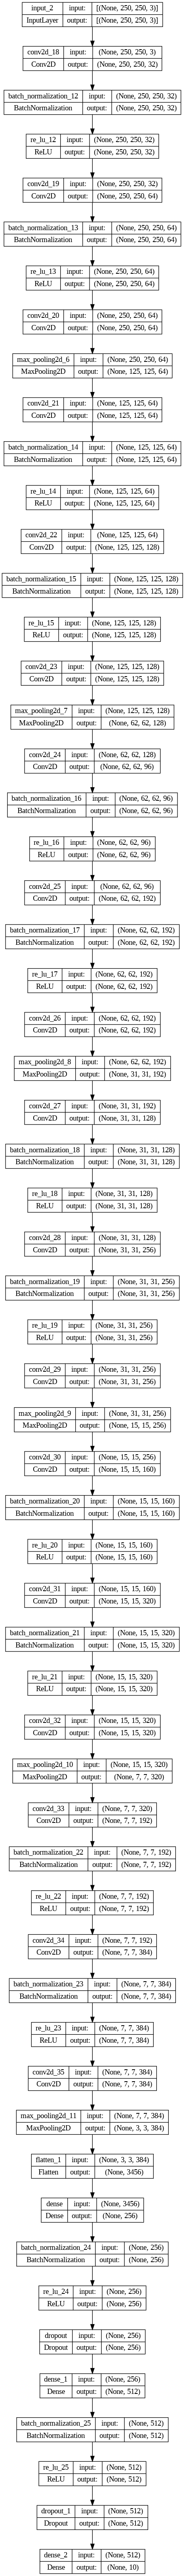

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
initial_learning_rate = 0.01 #начальный learning rate
model.compile(
    loss = "categorical_crossentropy", #функция потерь
    optimizer = optimizers.Adam(lr=initial_learning_rate), #оптимизатор
    metrics=['accuracy'] #метрики
)

In [ ]:
def lr_exp_decay(epoch, lr):#функция экпоненциального уменьшения learning rate
    k = 0.1
    return initial_learning_rate * np.exp(-k*epoch)
callbacks_list = [
    callbacks.ReduceLROnPlateau( #уменьшение lr при "застопорении" обучения
        monitor = 'val_loss', #за изменением какой метрики мы будем следить ('val_accuracy')
        patience = 2, #через сколько эпох сработает callback
        verbose = 1, #частота вывода работы callback'a
        factor = 0.1, #фактор уменьшения learning rate
        min_lr=1e-7), #минимально возможный learning rate
    callbacks.EarlyStopping( #ранняя остановка
        monitor = 'val_loss',
        patience = 5,
        verbose = 1),
    callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH + '/simple_best_model.hdf5', #путь до сохраняемой модели
        monitor='val_loss',
        verbose=1,
        save_best_only=True),#сохраняем только лучшие веса
    callbacks.LearningRateScheduler(
        lr_exp_decay, #функция по законам которой изменяется learning rate
        verbose=1
    )
]

In [ ]:
epochs=20 #количество эпох
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks=callbacks_list,
    batch_size = BATCH_SIZE,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20
390/390 [==============================] - ETA: 0s - loss: 2.6960 - accuracy: 0.1164
Epoch 1: val_loss improved from inf to 4.08565, saving model to models/simple_best_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


390/390 [==============================] - 323s 723ms/step - loss: 2.6960 - accuracy: 0.1164 - val_loss: 4.0856 - val_accuracy: 0.1180 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/20
390/390 [==============================] - ETA: 0s - loss: 2.3367 - accuracy: 0.1234
Epoch 2: val_loss improved from 4.08565 to 2.32845, saving model to models/simple_best_model.hdf5
390/390 [==============================] - 271s 695ms/step - loss: 2.3367 - accuracy: 0.1234 - val_loss: 2.3285 - val_accuracy: 0.1168 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/20
390/390 [==============================] - ETA: 0s - loss: 2.3020 - accuracy: 0.1217
Epoch 3: val_loss improved from 2.32845 to 2.29163, saving model to models/simple_best_model.hdf5
390/390 [==============================] - 271s 695ms/step - loss: 2.3020 - accuracy: 0.1217 - val_loss: 2.2916 - val_accuracy: 0.1299 - lr: 0.0082

Epoch 4: 

In [ ]:
model.load_weights('models/simple_best_model.hdf5')

In [ ]:
from tensorflow.keras.applications import MobileNetV2, DenseNet201, ResNet50 #испорт различных архитектур

In [ ]:
base_model = DenseNet201(
    weights='imagenet', #указываем какие веса мы будем брать
    input_shape=INPUT_SHAPE, #по умолчанию размер изображений - (224, 224)
    include_top=False #мы берем только сверточные слои(тело), полносвязные (голову) отрезаем
)
base_model.summary()

74836368/74836368 [==============================] - 3s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 256, 256, 3)          0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 125, 125, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
len(base_model.layers)

707

In [ ]:
model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation=None, kernel_initializer=initializers.GlorotNormal()))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(0.2))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation=None, kernel_initializer=initializers.GlorotNormal()))
model.add(layers.LeakyReLU(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(CLASS_NUM, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_3 (Dense)             (None, 512)               983552    
                                                                 
 batch_normalization_26 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)              

In [ ]:
def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * np.exp(-k*epoch)
callbacks_list = [
    callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        patience = 2,
        verbose = 1,
        min_lr=1e-7),
    callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        verbose = 1,
        restore_best_weights = True),
    callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH + '/transfer_best_model.hdf5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True),
    callbacks.LearningRateScheduler(
        lr_exp_decay,
        verbose=1
    )
]

In [ ]:
initial_learning_rate = 0.001
model.compile(
    loss = "categorical_crossentropy",
    optimizer = optimizers.Adam(lr=initial_learning_rate),
    metrics=['accuracy']
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
390/390 [==============================] - ETA: 0s - loss: 1.4142 - accuracy: 0.5249
Epoch 1: val_loss improved from inf to 1.26227, saving model to models/transfer_best_model.hdf5
390/390 [==============================] - 432s 815ms/step - loss: 1.4142 - accuracy: 0.5249 - val_loss: 1.2623 - val_accuracy: 0.5992 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048374180359595.
Epoch 2/20
390/390 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.7810
Epoch 2: val_loss improved from 1.26227 to 0.89554, saving model to models/transfer_best_model.hdf5
390/390 [==============================] - 303s 775ms/step - loss: 0.6063 - accuracy: 0.7810 - val_loss: 0.8955 - val_accuracy: 0.7301 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008187307530779819.
Epoch 3/20
390/390 [==============================] - ETA: 0s - loss: 0.3953 - accuracy:

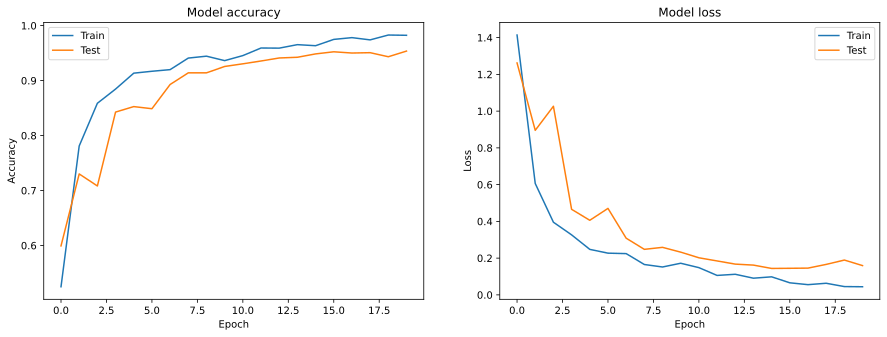

In [ ]:
epochs=20
history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = epochs,
        callbacks=callbacks_list,
        batch_size = BATCH_SIZE)
plot_history(history)

In [ ]:
model.load_weights(CHECKPOINT_PATH + '/transfer_best_model.hdf5')

In [ ]:
train_ds.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [ ]:
predictions = model.predict(test_ds, verbose=1) #предсказываем вероятности принадлежности классов для каждого изображения из test_ds
predictions = np.argmax(predictions, axis=-1) #берем индекс наибольшего значения этих вероятностей
predictions

209/209 [==============================] - 44s 197ms/step


array([2, 6, 4, ..., 1, 3, 4])

In [ ]:
label_map = (train_ds.class_indices) #получаем словарь соответствия меток классов и самих классов
label_map = dict((v,k) for k,v in label_map.items()) #меняем местами ключи и значения в этом словаре
predictions = [label_map[k] for k in predictions] #перекодируем наше предсказание

In [ ]:
test_submission = submission.copy()
test_submission['Category'] = pd.Series(predictions)
test_submission.to_csv('submission_car.csv', index=False)
print('Save submit')

files.download('submission_car.csv')

Save submit


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_df = pd.read_csv(DATA+"train.csv")
sample_submission = pd.read_csv(DATA+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Пример картинок (random sample)


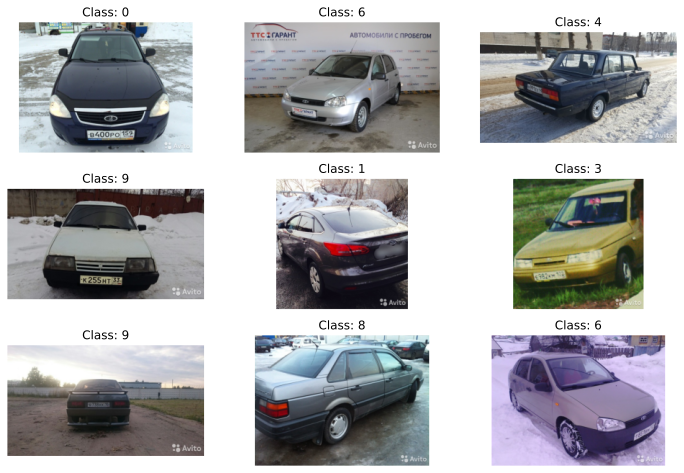

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+f'/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

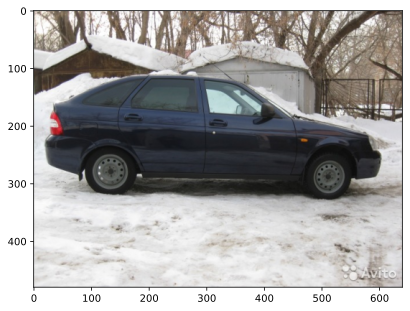

(640, 480)

In [ ]:
image = PIL.Image.open(DATA_DIR+'/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=VAL_SPLIT)

train_ds = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')

val_ds = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_ds = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=TEST_DIR,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
import os

# Проверка наличия файлов
invalid_files = []
for filename in sample_submission["Id"]:
    file_path = os.path.join(TEST_DIR, filename)
    if not os.path.exists(file_path):
        invalid_files.append(filename)

# Вывод списка недопустимых файлов
if invalid_files:
    print("Недопустимые файлы:", invalid_files)
else:
    print("Все файлы в порядке.")


Все файлы в порядке.


In [ ]:
num_classes = 10



model = keras.Sequential([
    keras.Input(shape = input_shape),
    keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation = 'sigmoid'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
opt = SGD(learning_rate=0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
epochs=20
history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = epochs
)

Epoch 1/20
827/827 [==============================] - 72s 87ms/step - loss: 2.2758 - accuracy: 0.1414 - val_loss: 2.2825 - val_accuracy: 0.1357
Epoch 2/20
827/827 [==============================] - 73s 89ms/step - loss: 2.2617 - accuracy: 0.1565 - val_loss: 2.2680 - val_accuracy: 0.1503
Epoch 3/20
827/827 [==============================] - 73s 89ms/step - loss: 2.2455 - accuracy: 0.1663 - val_loss: 2.2507 - val_accuracy: 0.1636
Epoch 4/20
827/827 [==============================] - 73s 88ms/step - loss: 2.2115 - accuracy: 0.1914 - val_loss: 2.2300 - val_accuracy: 0.1790
Epoch 5/20
827/827 [==============================] - 73s 88ms/step - loss: 2.1412 - accuracy: 0.2297 - val_loss: 2.1835 - val_accuracy: 0.2018
Epoch 6/20
827/827 [==============================] - 73s 89ms/step - loss: 2.0233 - accuracy: 0.2821 - val_loss: 2.1153 - val_accuracy: 0.2319
Epoch 7/20
827/827 [==============================] - 73s 88ms/step - loss: 1.8201 - accuracy: 0.3697 - val_loss: 2.1194 - val_accuracy:

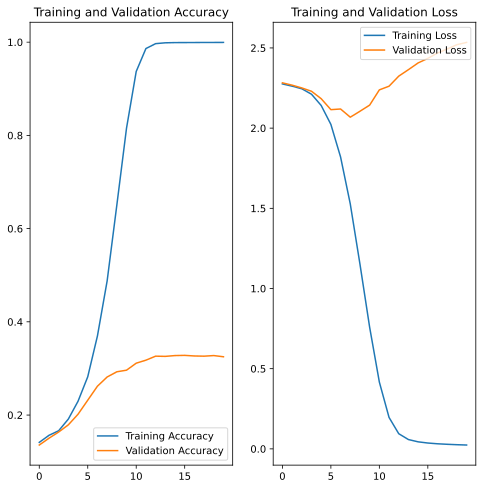

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict(test_ds, steps=len(test_ds), verbose=1)

418/418 [==============================] - 19s 44ms/step


In [ ]:
print(predictions.shape)

(6675, 10)


In [ ]:
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_ds.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submissioncar1.csv', index=False)
print('Save submit')

Save submit


In [ ]:
from google.colab import files

filenames_with_dir = test_ds.filenames
submission = pd.DataFrame({'Id': filenames_with_dir, 'Category': predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/', '')
submission.to_csv('submission1.csv', index=False)

files.download('submissioncar1.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>